# Bank Marketing Mini-Portfolio

**What I will  do :**

1) Basic cleaning → save `bank_clean.csv`  
2) K-Means clustering (`balance`, `age`, `campaign`)  
3) Simple charts (bar, pie, scatter)  
4) Correlations (numeric subset)  

> This notebook uses **matplotlib** (no seaborn) and does not set custom colors.


In [ ]:
# 0) Setup: Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

print('Libraries ready')

Libraries ready


## 1) Uploading Dataset (CSV Kaggle Bank Marketing)

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your CSV here

Saving bank.csv to bank (2).csv
CSV_NAME set to: bank.csv


## 2) Load & quick look

In [ ]:
df = pd.read_csv(CSV_NAME)
print('Shape:', df.shape)
df.head()

Shape: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## 3) Basic understanding & missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [ ]:
df.describe().T.head(20)

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


In [ ]:
missing = df.isnull().mean().sort_values(ascending=False)
missing.head(20)

,0
age,0.0
job,0.0
marital,0.0
education,0.0
default,0.0
balance,0.0
housing,0.0
loan,0.0
contact,0.0
day,0.0


## 4) Very light cleaning
- Drop duplicates  
- Fill numeric with median  
- Fill categorical with 'Unknown'  
- Create simple buckets (age, balance) if present


In [ ]:
# Drop duplicates
df = df.drop_duplicates().copy()

# Fill numeric/categorical
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

for col in num_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna('Unknown')

# Buckets
if 'age' in df.columns:
    bins_age = [0,25,35,45,55,65,120]
    labels_age = ['<=25','26-35','36-45','46-55','56-65','65+']
    df['age_bucket'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, right=True, include_lowest=True)

if 'balance' in df.columns:
    bins_bal = [-1e12,0,500,1000,5000,10000,1e12]
    labels_bal = ['<=0','1-500','501-1000','1001-5000','5001-10000','>10000']
    df['balance_bucket'] = pd.cut(df['balance'], bins=bins_bal, labels=labels_bal, right=True, include_lowest=True)

print('Cleaned. Preview:')
df.head()

Cleaned. Preview:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_bucket,balance_bucket
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,56-65,1001-5000
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,56-65,1-500
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,36-45,1001-5000
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,46-55,1001-5000
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,46-55,1-500


## 5) Save processed CSV (for reproducibility / Tableau later)

In [ ]:
PROC_NAME = 'bank_clean.csv'
df.to_csv(PROC_NAME, index=False)
print('Saved:', PROC_NAME)

Saved: bank_clean.csv


## 6) K-Means clustering (with scaling)
- Features: `balance`, `age`, `campaign` (modify if needed)  
- Clusters: 5 (you can change `n_clusters`)


In [ ]:
features = ['balance','age','campaign']
# Ensure the columns exist;
features = [f for f in features if f in df.columns]
if len(features) < 2:
    raise ValueError('Not enough numeric features found. Please adjust the feature list to match your CSV columns.')

X = df[features].copy()
X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)

df['cluster'] = labels
df['cluster'].value_counts()

,count
cluster,
0,6401
2,3409
1,765
3,520
4,67


## 7) Plots (matplotlib only)

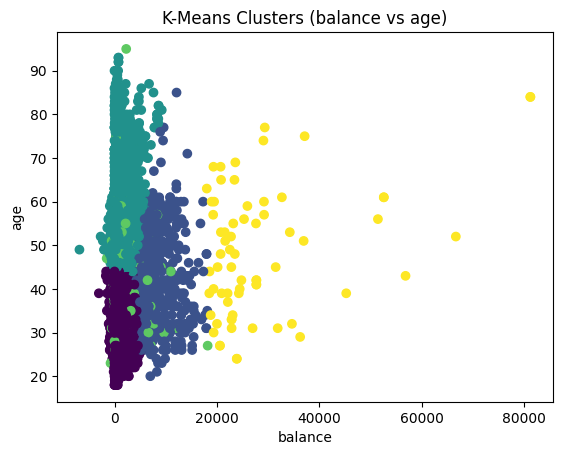

In [ ]:
# Scatter: balance vs age colored by cluster
if {'balance','age'}.issubset(df.columns):
    plt.scatter(df['balance'], df['age'], c=df['cluster'])
    plt.xlabel('balance'); plt.ylabel('age'); plt.title('K-Means Clusters (balance vs age)')
    plt.show()
else:
    print('Skipping scatter: need both balance and age columns.')

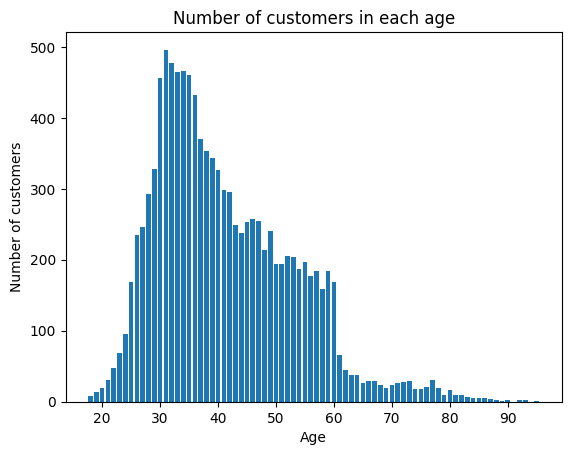

In [ ]:
# Bar: number of customers per age
if 'age' in df.columns:
    vc_age = df['age'].value_counts().sort_index()
    plt.bar(vc_age.index, vc_age.values)
    plt.xlabel('Age'); plt.ylabel('Number of customers')
    plt.title('Number of customers in each age')
    plt.show()
else:
    print('Skipping bar: age column not found.')

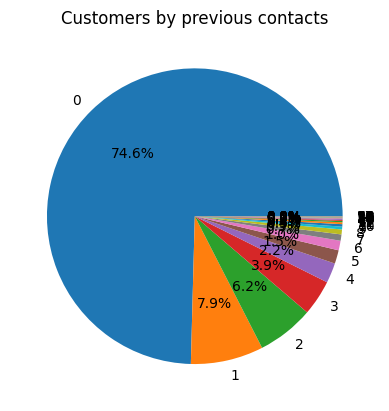

In [ ]:
# Pie: distribution by 'previous'
if 'previous' in df.columns:
    counts = df['previous'].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.title('Customers by previous contacts')
    plt.show()
else:
    print("Column 'previous' not found; skipping pie chart.")

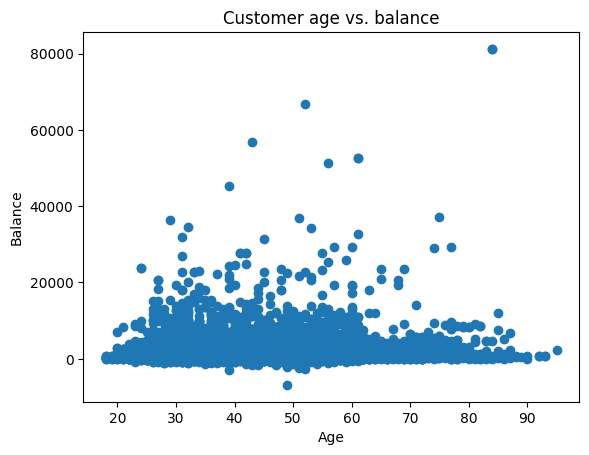

In [ ]:
# Scatter: age vs balance (plain)
if {'age','balance'}.issubset(df.columns):
    plt.scatter(df['age'], df['balance'])
    plt.xlabel('Age'); plt.ylabel('Balance')
    plt.title('Customer age vs. balance')
    plt.show()
else:
    print('Skipping scatter: need both age and balance columns.')

## 8) Correlations

In [ ]:
subset = [c for c in ['age','balance','day','duration','campaign','pdays','previous'] if c in df.columns]
if subset:
    corr = df[subset].corr()
    corr
    if 'previous' in corr.columns:
        print("\nTop correlated with 'previous':")
        print(corr['previous'].sort_values(ascending=False).head(5))
else:
    print('No matching numeric columns found for correlation subset.')


Top correlated with 'previous':
previous    1.000000
pdays       0.507272
balance     0.030805
age         0.020169
duration   -0.026716
Name: previous, dtype: float64


In [ ]:
# Optional: correlation to target y
if 'y' in df.columns:
    df['y_bin'] = (df['y'].astype(str).str.lower()=='yes').astype(int)
    cols_y = list(set(subset + ['y_bin']))
    corr_to_y = df[cols_y].corr()['y_bin'].sort_values(ascending=False)
    print('\nTop correlated with y_bin:')
    print(corr_to_y.head(10))
else:
    print("No column 'y' found; skipping y correlation.")

No column 'y' found; skipping y correlation.


## 9) Download outputs (optional)
Use the code block below in Colab to download `bank_clean.csv` to your computer.


In [ ]:
try:
    from google.colab import files
    files.download('bank_clean.csv')
except Exception as e:
    print('Created in Colab, if not using colab you can manually download bank_clean.csv from the working directory.')